In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy import stats
from cv_mod import initialize_dfs, calc_area_simps, depositions, pre_treatments, treatments, ldhs, calc_area_trapz, populate_mean_dfs, compute_norm_minmax
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.formula.api as smf
from patsy import dmatrices
%matplotlib inline
sns.set_theme(style='whitegrid', color_codes=True)
sns.set_style('whitegrid',  {'axes.grid' : False})
sns.set_context('paper')
plt.rcParams.update({'font.sans-serif':'Cambria'})
plt.rcParams["axes.edgecolor"] = 'black'

In [2]:
# colours

#depositions_colours = dict(zip(depositions, ['#ff08c9', '#ff6043', '#c3b41c', '#52de9a']))
#pre_treatment_colours = dict(zip(pre_treatments, ['#ff0000', '#000000']))
#ldhs_colours = dict(zip(ldhs, ['#ffe6ff', '#fff3e6']))

#depositions_colours = dict(zip(depositions, cm.get_cmap('viridis')(np.linspace(0.2, 0.8, 4)))) # viridis
depositions_colours = dict(zip(depositions, np.concatenate([np.array([[0, 0, 0, 1]]), cm.get_cmap('viridis')(np.linspace(0.4, 0.8, 3))]))) # viridis with black
depositions_colours = dict(zip(depositions, ['#CE3257', '#E8A508', '#432EFF', '#57B312'])) # camis colours
#depositions_colours = dict(zip(depositions, ['#EF476F', '#FFD166', '#06D6A0', '#118AB2'])) # my colours
#depositions_colours = dict(zip(depositions, ['#2D708E','#29AF7F', '#B8DE29', '#FDE725'])) # biancas viridis colours '#000000','#482677','#2D708E','#29AF7F','#B8DE29','#FDE725'




ldhs_colours = dict(zip(ldhs, ['#e0e0e0', '#f2f2f2']))

In [3]:
dfs_original, dfs_repeat = initialize_dfs()

data_original file not found, loading excel files


100%|███████████████████████████████████████████████| 70/70 [02:00<00:00,  1.73s/it, loaded: drop_non-annealed_naoh_fe]


done
data_repeat file not found, loading excel files


100%|███████████████████████████████████████████████| 70/70 [02:08<00:00,  1.83s/it, loaded: drop_non-annealed_naoh_fe]

done


In [4]:
dfs_mean = populate_mean_dfs(dfs_original, dfs_repeat)

In [5]:
# populate dataframe containing areas
df_data = []
for deposition in depositions:
    for pre_treatment in pre_treatments:
        for treatment in treatments:
            if (deposition=='none'):
                    name = f'{deposition}_{pre_treatment}_{treatment}'
                    area = calc_area_simps(dfs_mean[name].copy())
                    df_data.append([deposition, pre_treatment, treatment, 'none', area])
            else:
                 for ldh in ldhs:
                    name = f'{deposition}_{pre_treatment}_{treatment}_{ldh}'
                    area = calc_area_simps(dfs_mean[name].copy())
                    df_data.append([deposition, pre_treatment, treatment, ldh, area])

df_areas = pd.DataFrame(data=df_data, columns=['deposition', 'pre-treatment', 'treatment', 'ldh', 'area'])
df_areas

,deposition,pre-treatment,treatment,ldh,area
0,none,annealed,untreated,none,0.965899
1,none,annealed,hno3,none,1.047376
2,none,annealed,h2so4,none,0.766796
3,none,annealed,mix,none,1.133281
4,none,annealed,naoh,none,0.894436
...,...,...,...,...,...
65,drop,non-annealed,h2so4,fe,0.603209
66,drop,non-annealed,mix,co,0.825978
67,drop,non-annealed,mix,fe,0.807486
68,drop,non-annealed,naoh,co,1.080294


# single cv

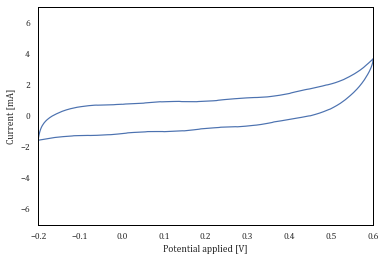

In [6]:
name = 'ageing_non-annealed_h2so4_co'
df_plot = dfs_original[name]
fig = sns.lineplot(data=df_plot, x='Potential applied [V]', y='Current [mA]', estimator=None, sort=False)
plt.ylim(-7, 7)
plt.xlim(-0.2, 0.6)
plt.savefig(f'{name}.png')

# multi cvs

max_current: 3.843065531696764, min_current: -1.6422469224037524


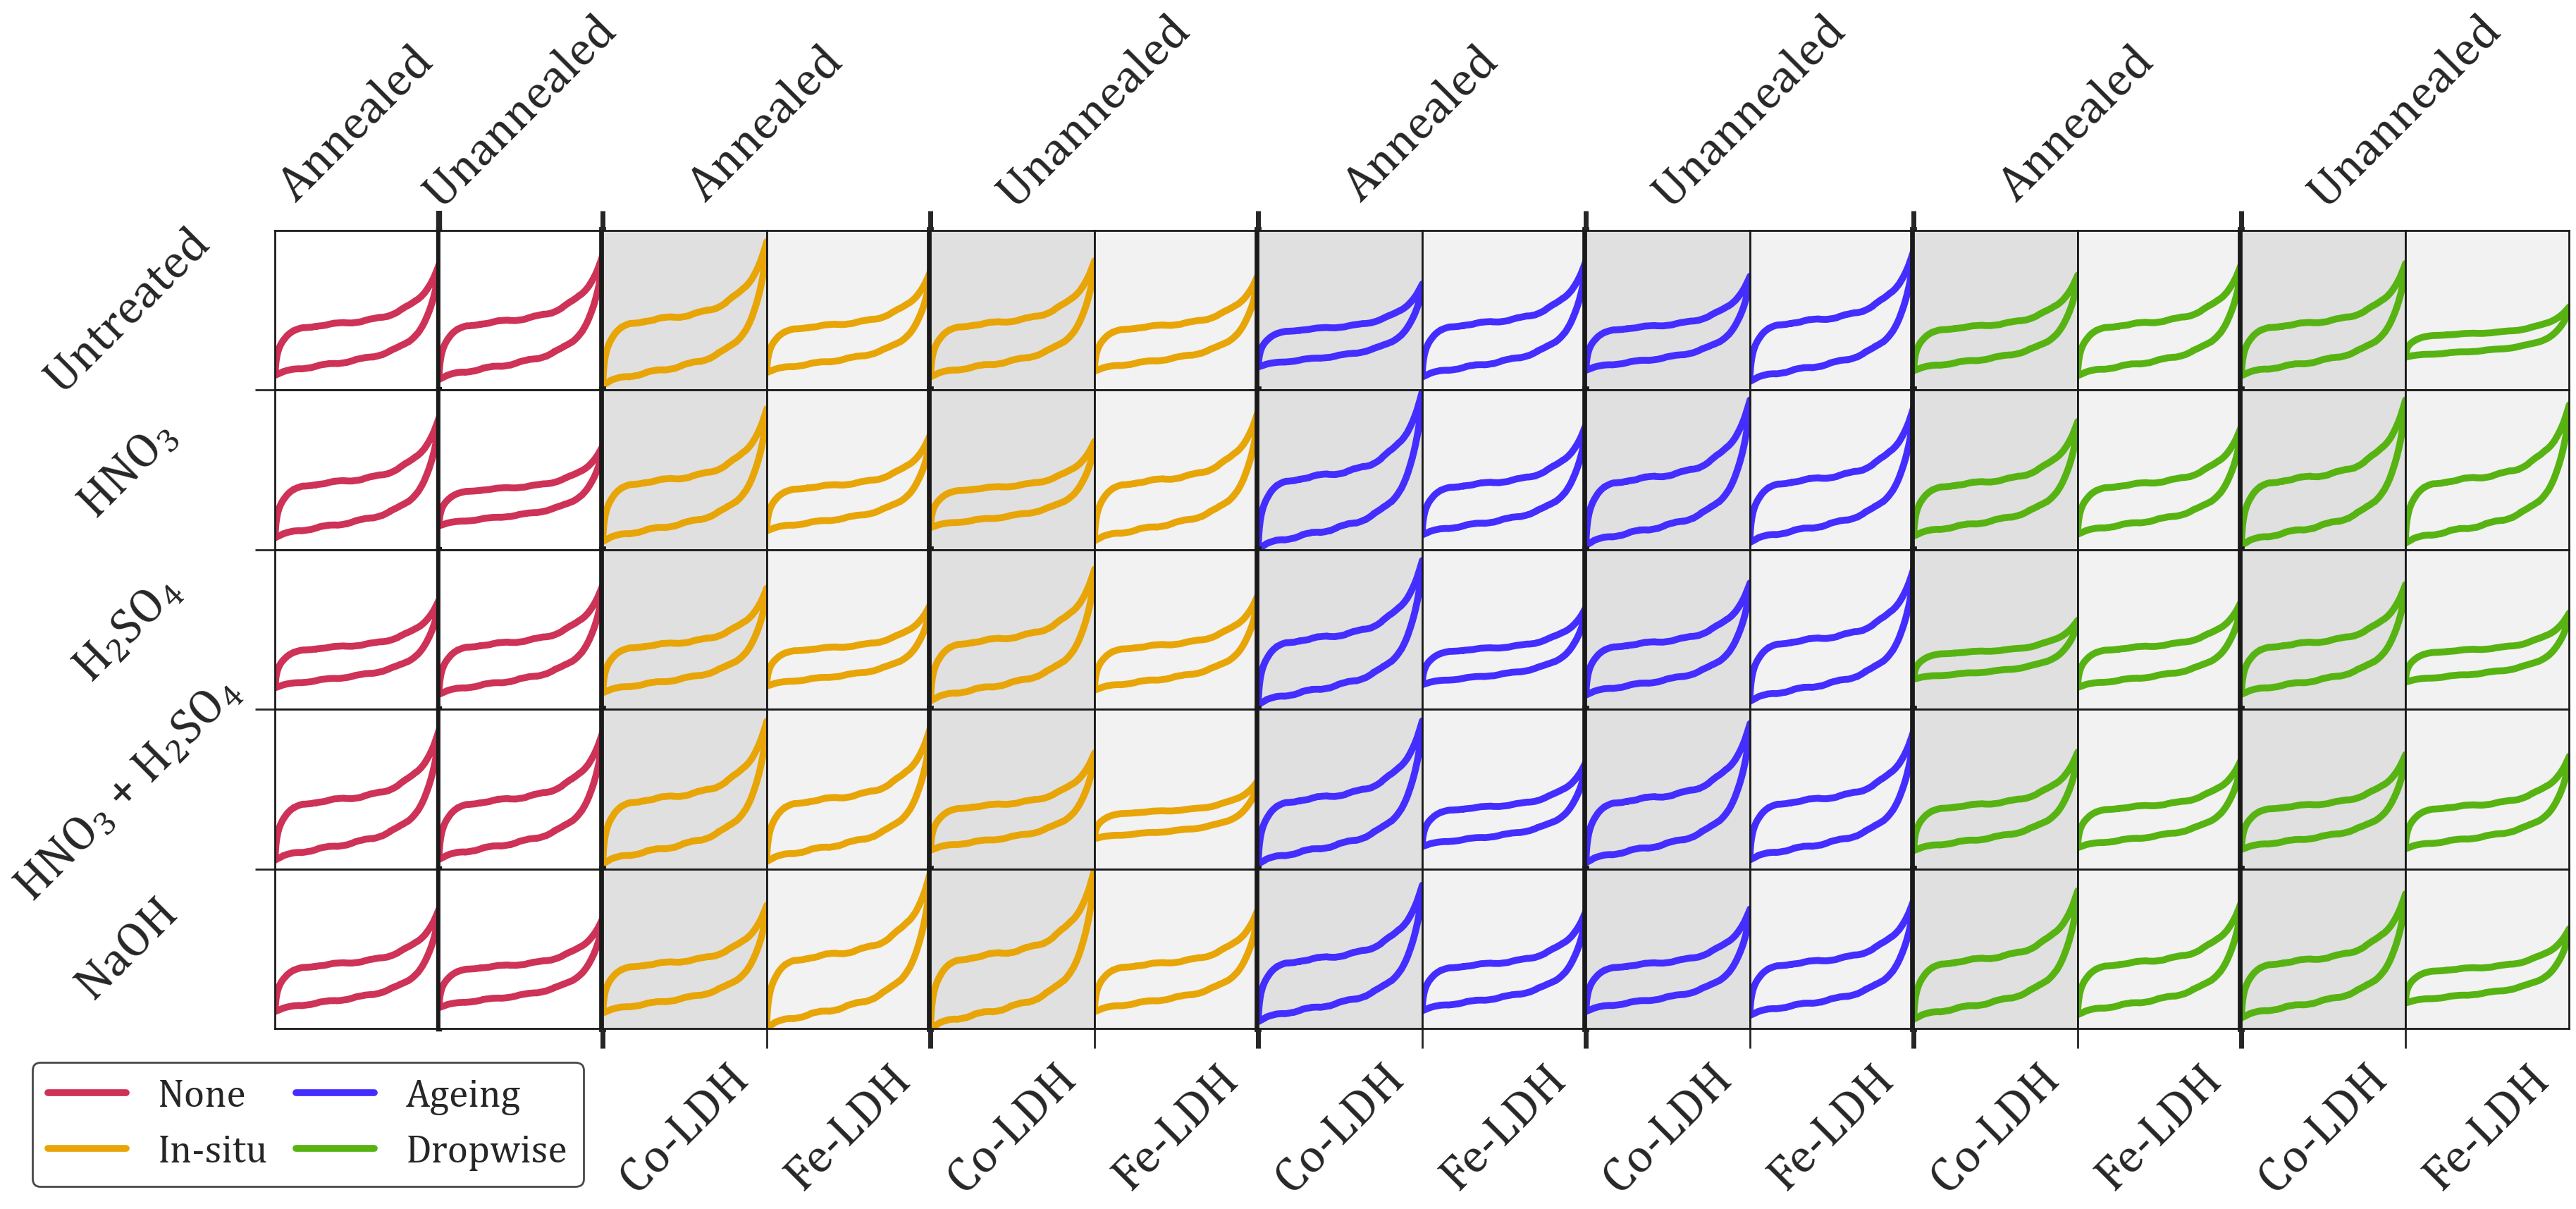

In [7]:
# parameters
plot_lw = 7

# figure setup
nrows = 5
ncols = 14
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(ncols*3, nrows*3), 
                         #tight_layout=True,
                         sharex = True,
                         sharey = True,
                         dpi=100)
fig.subplots_adjust(wspace=0, hspace=0)
#axes[0, 0].set_xticks([-0.2, 0.2, 0.6])
#axes[0, 0].set_yticks([0, 0.5, 1])

# plot
min_current, max_current = compute_norm_minmax(dfs_mean)
j = -1
for deposition in depositions:
    if (deposition == 'none'):
        for pre_treatment in pre_treatments:
            i = -1
            j += 1
            for treatment in treatments:
                i += 1
                name = f'{deposition}_{pre_treatment}_{treatment}'
                df_mean = dfs_mean[name].copy()
                df_mean['Current [mA]'] = (df_mean['Current [mA]'].values - min_current)/(max_current - min_current) # normalisation
                
                axes[i, j].plot(df_mean['Potential applied [V]'].values, df_mean['Current [mA]'].values, color=depositions_colours[deposition], lw=plot_lw)
                axes[i, j].set_ylim(0, 1)
                axes[i, j].set_xlim(-0.2, 0.6)
                #axes[i, j].set_title(name)
    else:      
        for pre_treatment in pre_treatments:
            for ldh in ldhs:
                i = -1
                j += 1
                for treatment in treatments:
                    i += 1
                    name = f'{deposition}_{pre_treatment}_{treatment}_{ldh}'   
                    df_mean = dfs_mean[name].copy()
                    df_mean['Current [mA]'] = (df_mean['Current [mA]'].values - min_current)/(max_current - min_current) # normalisation
                    
                    axes[i, j].plot(df_mean['Potential applied [V]'].values, df_mean['Current [mA]'].values, color=depositions_colours[deposition], lw=plot_lw)
                    axes[i, j].set_ylim(0, 1)
                    axes[i, j].set_xlim(-0.2, 0.6)
                    axes[i, j].set_facecolor(ldhs_colours[ldh])
        
# no axes labels
for i in range(nrows):
    for j in range(ncols): 
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        for spine in axes[i, j].spines.values():
            spine.set_edgecolor('k')
            spine.set_linewidth(2)
        
# x labels and tickmark dividers                  
for j in range(ncols):
    # ldh labels
    ax = axes[nrows - 1, j]
    if (j > 1):
        ax.xaxis.tick_bottom()
        ax.set_xticks([-0.2])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(width=2, length=20, direction='out')
        if (j%2 == 0):
            ax.set_xlabel('Co-LDH', rotation=45, fontsize=50)
        else:
            ax.set_xlabel('Fe-LDH', rotation=45, fontsize=50) 
            
    # anneal/unannealed
    ax = axes[0, j]
    if (j == 0):
        ax.set_xlabel('Annealed', rotation=45, fontsize=50)
        ax.xaxis.set_label_coords(0.5, 2.2)
    elif (j == 1):
        ax.set_xlabel('Unannealed', rotation=45, fontsize=50)
        ax.xaxis.set_label_coords(0.5, 2.4)
        ax.xaxis.tick_top()
        ax.set_xticks([-0.2, 0.6])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(width=2, length=20)
    elif (j in [2, 6, 10]):
        ax.set_xlabel('Annealed', rotation=45, fontsize=50)
        ax.xaxis.set_label_coords(1, 2.2)
        ax.xaxis.tick_top()
        ax.set_xticks([-0.2])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(width=2, length=20)
    elif (j in [4, 8, 12]):
        ax.set_xlabel('Unannealed', rotation=45, fontsize=50)
        ax.xaxis.set_label_coords(1, 2.4)
        ax.xaxis.tick_top()
        ax.set_xticks([-0.2])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(width=2, length=20)        
        
# y labels and tickmark dividers
row_labels = ['Untreated', '$\mathregular{HNO_3}$', '$\mathregular{H_2SO_4}$', '$\mathregular{HNO_3}$ + $\mathregular{H_2SO_4}$', 'NaOH']
for i in range(nrows):
    ax = axes[i, 0]
    ax.set_ylabel(row_labels[i], rotation=45, fontsize=50)
    ax.yaxis.set_label_coords(-0.8, 0.4)   
    if (i != nrows - 1):
        ax.yaxis.tick_left()
        ax.set_yticks([0])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_tick_params(width=2, length=20)

# thick lines for annealed/unannealed
for i in range(nrows):
    axes[i, 0].spines['right'].set_linewidth(6)
    axes[i, 1].xaxis.set_tick_params(width=6)     
    for j in range(1, ncols - 1, 2):
        # axes[i, j].spines['right'].set_linestyle('dashed')
        # axes[i, j].spines['right'].set_capstyle('butt')
        axes[i, j].spines['right'].set_linewidth(7)
        axes[i, j + 1].xaxis.set_tick_params(width=5)   
        
# legend
legend_lines = [Line2D([0], [0], color=deposition_colour, lw=plot_lw) for deposition_colour in depositions_colours.values()]
legend = axes[0, 0].legend(legend_lines, 
                  ['None', 'In-situ', 'Ageing', 'Dropwise'], 
                  edgecolor='k',
                  fontsize=40, 
                  loc='center left', 
                  mode='expand', 
                  ncol=2, 
                  bbox_to_anchor=(-1.6, -7.1, 3.6, 5))
legend.get_frame().set_linewidth(2) 

# save
#fig.savefig('plots\cvs.png', bbox_inches='tight')

# category boxplots

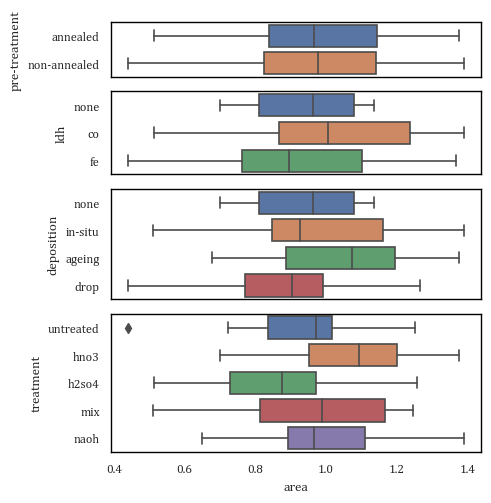

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(5, 5), tight_layout=True, sharex=True, dpi=100, gridspec_kw=dict(height_ratios=[2/14, 3/14, 4/14, 5/14]))
#gs = fig.add_gridspec(2, 1)
#ax = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_areas, x='area', y='pre-treatment', ax=axes[0])
sns.boxplot(data=df_areas, x='area', y='ldh', ax=axes[1])
sns.boxplot(data=df_areas, x='area', y='deposition', ax=axes[2])
sns.boxplot(data=df_areas, x='area', y='treatment', ax=axes[3])
for ax in axes:
    if (ax != axes[3]):
        ax.set_xlabel('')
#plt.savefig('boxplots.png')

# swarm plots

C:\Users\angol\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\angol\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='area', ylabel='treatment'>

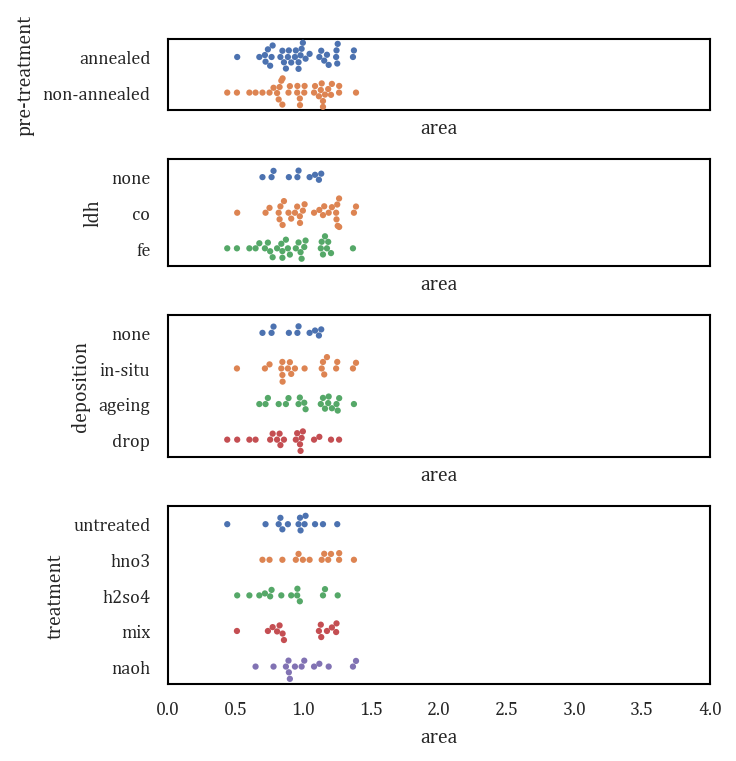

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(5, 5), tight_layout=True, sharex=True, dpi=150, gridspec_kw=dict(height_ratios=[2/14, 3/14, 4/14, 5/14]))
for ax in axes:
    ax.set_xlim(0, 4)
    if (ax != axes[3]):
        ax.set_xlabel('')    

sns.swarmplot(data=df_areas, x='area', s=3, y='pre-treatment', ax=axes[0])
sns.swarmplot(data=df_areas, x='area', s=3, y='ldh', ax=axes[1])
sns.swarmplot(data=df_areas, x='area', s=3, y='deposition', ax=axes[2])
sns.swarmplot(data=df_areas, x='area', s=3, y='treatment', ax=axes[3])


# violin plots

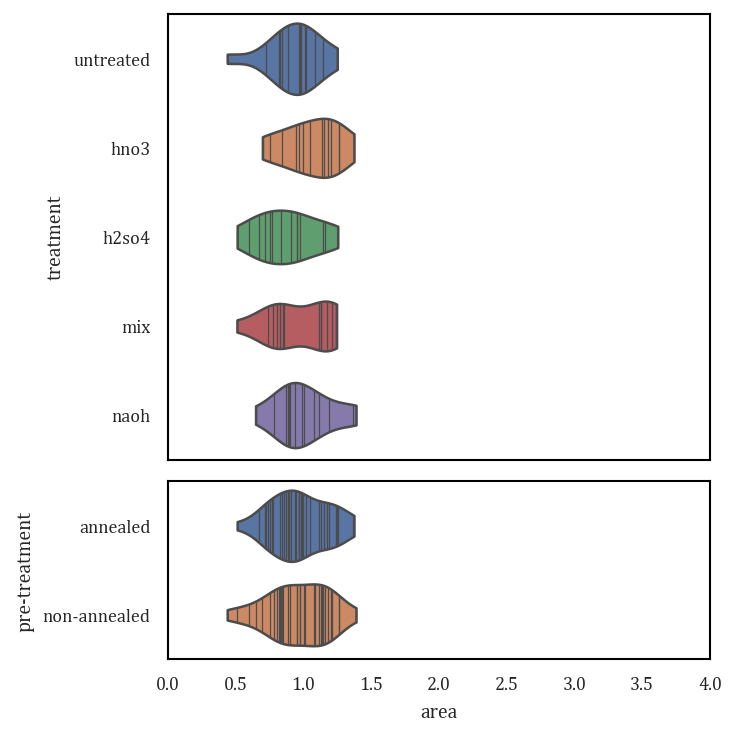

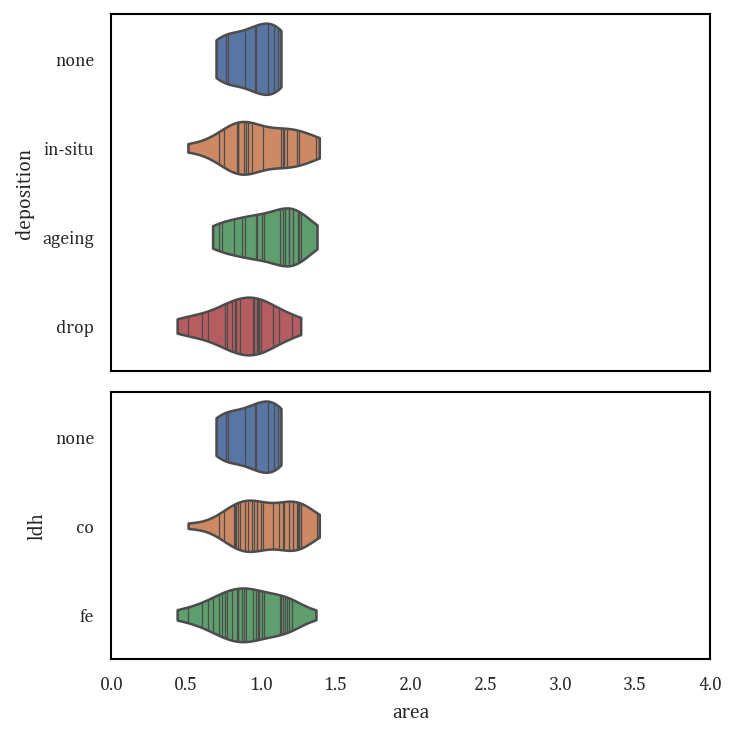

In [10]:
def plot_violin(subplots, height_ratio):
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), tight_layout=True, sharex=True, dpi=150, gridspec_kw=dict(height_ratios=height_ratio))
    for ax, subplot in zip(axes, subplots):
        ax = sns.violinplot(data=df_areas, x='area', y=subplot, ax=ax, inner='stick', cut=0)
        ax.set_xlim(0, 4)
        if (ax == axes[0]): ax.set_xlabel('')

plot_violin(['treatment', 'pre-treatment'], [5/7, 2/7])    
plot_violin(['deposition', 'ldh'], [4/7, 3/7])      

# Raincloud plot

C:\Users\angol\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\angol\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


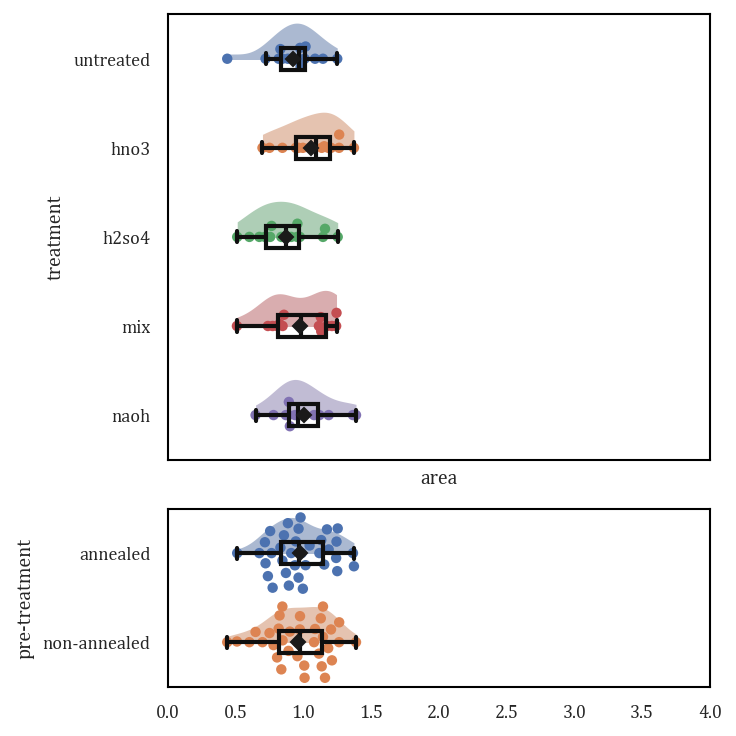

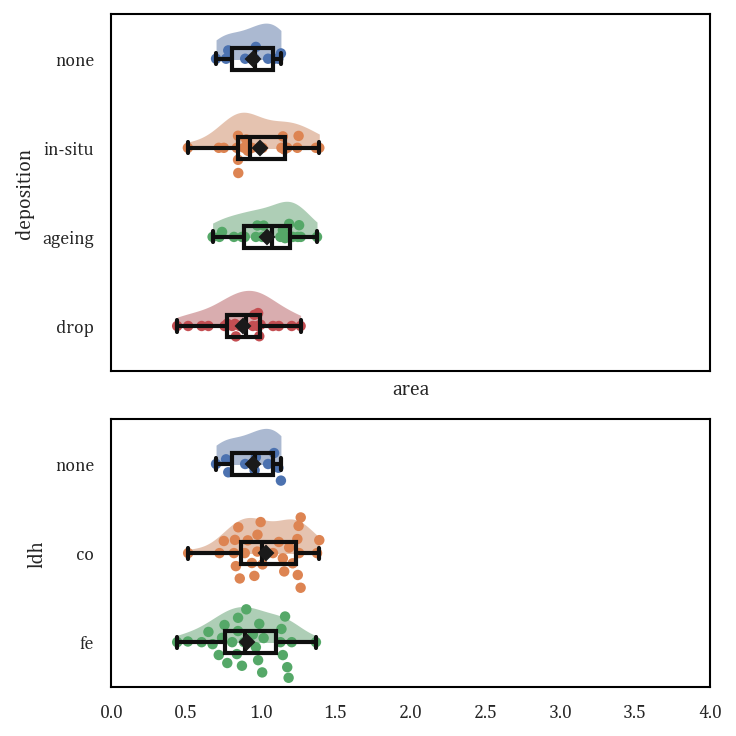

In [11]:
# def plot_violin(subplots, height_ratio):
#     fig, axes = plt.subplots(2, 1, figsize=(5, 5), tight_layout=True, sharex=True, dpi=150, gridspec_kw=dict(height_ratios=height_ratio))
#     for ax, subplot in zip(axes, subplots):
#         ax = sns.violinplot(data=df_areas, x='area', y=subplot, ax=ax, inner='stick', cut=0)
#         ax.set_xlim(0, 4)
#         if (ax == axes[0]): ax.set_xlabel('')
        
def plot_raincloud(subplots, height_ratios):
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), tight_layout=True, sharex=True, dpi=150, gridspec_kw=dict(height_ratios=height_ratios))
    for ax, subplot in zip(axes, subplots):
        # violin plots
        sns.violinplot(data=df_areas, x='area', y=subplot, ax=ax, inner=None, cut=0, linewidth=0, scale='width')
        for item in ax.collections:
            x0, y0, width, height = item.get_paths()[0].get_extents().bounds
            item.set_clip_path(plt.Rectangle((x0, y0), width, height/2,
                           transform=ax.transData))
            item.set_alpha(0.5)
        # strip plots
        sns.swarmplot(data=df_areas, x='area', y=subplot, ax=ax, zorder=1)
        num_items = len(ax.collections)
        for item in ax.collections[num_items:]:
            item.set_offsets(item.get_offsets() + 0.15)

        # box plots
        sns.boxplot(data=df_areas, x='area', y=subplot, ax=ax,
                    color='k',
                    width=0.25,
                    showfliers=False,
                    showmeans=True, 
                    meanprops=dict(marker='D', markerfacecolor='k', markeredgecolor='k', markersize=5, zorder=3),
                    boxprops=dict(facecolor=(0, 0, 0, 0), linewidth=2, zorder=3),
                    whiskerprops=dict(linewidth=2),
                    capprops=dict(linewidth=2),
                    medianprops=dict(linewidth=2)) 

        ax.set_xlim(0, 4)
        if (ax != axes[0]): ax.set_xlabel('')

plot_raincloud(['treatment', 'pre-treatment'], [5/7, 2/7])    
plot_raincloud(['deposition', 'ldh'], [4/7, 3/7])   


# anova

In [12]:
data = []

# pre-treatment
df_pt_gb = df_areas[['pre-treatment', 'area']].groupby('pre-treatment')
data.append(stats.f_oneway(df_pt_gb.get_group('annealed')['area'], 
                           df_pt_gb.get_group('non-annealed')['area']))

# ldh
df_ldh_gb = df_areas[['ldh', 'area']].groupby('ldh')
data.append(stats.f_oneway(df_ldh_gb.get_group('none')['area'],
                           df_ldh_gb.get_group('co')['area'], 
                           df_ldh_gb.get_group('fe')['area'])) 

# deposition
df_d_gb = df_areas[['deposition', 'area']].groupby('deposition')
data.append(stats.f_oneway(df_d_gb.get_group('none')['area'], 
                           df_d_gb.get_group('in-situ')['area'],
                           df_d_gb.get_group('ageing')['area'],
                           df_d_gb.get_group('drop')['area'])) 

# treatment
df_t_gb = df_areas[['treatment', 'area']].groupby('treatment')
data.append(stats.f_oneway(df_t_gb.get_group('untreated')['area'], 
                           df_t_gb.get_group('hno3')['area'],
                           df_t_gb.get_group('h2so4')['area'],
                           df_t_gb.get_group('mix')['area'],
                           df_t_gb.get_group('naoh')['area']))
df_anova = pd.DataFrame(data=data, columns=['f-test value', 'p-value'], index=['pre-treatment', 'ldh', 'deposition', 'treatment'])
df_anova

,f-test value,p-value
pre-treatment,0.076351,0.783142
ldh,2.693086,0.074997
deposition,2.177052,0.098998
treatment,1.584109,0.189085


# interaction plot

In [13]:
def binary_interaction_plot(df_areas,
                            ax,
                            x='treatment', 
                            z='pre-treatment'):
    # order and labels
    if x == 'treatment':
        x_order = ['untreated', 'hno3', 'h2so4', 'mix', 'naoh']
        x_labels = ['Untreated', '$\mathregular{HNO_3}$', '$\mathregular{H_2SO_4}$', '$\mathregular{HNO_3}$ + $\mathregular{H_2SO_4}$', 'NaOH']
    elif x == 'pre-treatment':
        x_order = ['annealed', 'non-annealed']
        x_labels = ['Annealed', 'Unannealed']
    elif x == 'ldh':
        x_order = ['none', 'co', 'fe']
        x_labels = ['None', 'Co-LDH', 'Fe-LDH']
    elif x == 'deposition':
        x_order = ['none', 'in-situ', 'ageing', 'drop']
        x_labels = ['None', 'In-situ', 'Ageing', 'Dropwise']

    if z == 'treatment':
        z_order = ['untreated', 'hno3', 'h2so4', 'mix', 'naoh']
        z_labels = ['Untreated', '$\mathregular{HNO_3}$', '$\mathregular{H_2SO_4}$', '$\mathregular{HNO_3}$ + $\mathregular{H_2SO_4}$', 'NaOH']
    elif z == 'pre-treatment':
        z_order = ['annealed', 'non-annealed']
        z_labels = ['Annealed', 'Unannealed']
    elif z == 'ldh':
        z_order = ['none', 'co', 'fe']
        z_labels = ['None', 'Co-LDH', 'Fe-LDH']
    elif z == 'deposition':
        z_order = ['none', 'in-situ', 'ageing', 'drop']
        z_labels = ['None', 'In-situ', 'Ageing', 'Dropwise']
    
    # numerical encoding of variables 
    df_areas_enc = df_areas.copy()
    x_conditions = [df_areas_enc[x] == x_label for x_label in x_order]
    x_choices = range(len(x_order))
    df_areas_enc['x_encoded'] = np.select(x_conditions, x_choices)
    z_conditions = [df_areas_enc[z] == z_label for z_label in z_order]
    z_choices = range(len(z_order))
    df_areas_enc['z_encoded'] = np.select(z_conditions, z_choices)
    
    # groupby
    df_means = df_areas_enc.groupby(['z_encoded', 'x_encoded'], as_index=False).mean()
    df_means.rename(columns={'area': 'mean'}, inplace=True)
                            
    # plot
    z_colours=cm.get_cmap('viridis')(np.linspace(0.2, 0.8, len(z_order))).tolist()
    sns.swarmplot(data=df_areas_enc, x='x_encoded', y='area', hue='z_encoded', ax=ax, palette=z_colours)
    sns.lineplot(data=df_means, x='x_encoded', y='mean', hue='z_encoded', ax=ax, palette=z_colours)
    sns.scatterplot(data=df_means, x='x_encoded', y='mean', hue='z_encoded', marker='D', s=50, ax=ax, palette=z_colours)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('')
    ax.set_ylabel('Enclosed area')                        
    ax.set_ylim(0.0, 5.0)
    legend_lines = [Line2D([], [], color=z_colour, marker='o') for z_colour in z_colours]
    legend = ax.legend(legend_lines,
                     z_labels,
                     fontsize=10,
                     edgecolor='k',
                     loc='upper right')                         

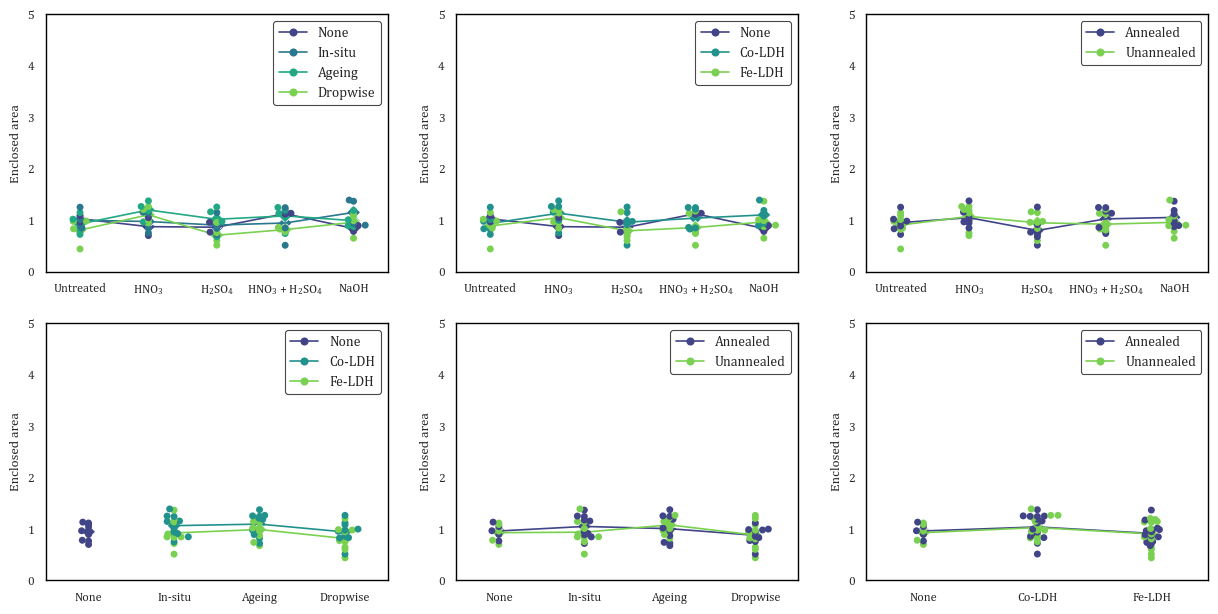

In [14]:
fig, axes = plt.subplots(2, 3, dpi=100, figsize=(3*5, 1.5*5))
binary_interaction_plot(df_areas, 
                        axes[0, 0],
                        x='treatment', 
                        z='deposition')      
binary_interaction_plot(df_areas, 
                        axes[0, 1],
                        x='treatment', 
                        z='ldh')
binary_interaction_plot(df_areas, 
                        axes[0, 2],
                        x='treatment', 
                        z='pre-treatment')
binary_interaction_plot(df_areas, 
                        axes[1, 0],
                        x='deposition', 
                        z='ldh')
binary_interaction_plot(df_areas, 
                        axes[1, 1],
                        x='deposition', 
                        z='pre-treatment')
binary_interaction_plot(df_areas, 
                        axes[1, 2],
                        x='ldh', 
                        z='pre-treatment')

# modelling

## linear model

In [15]:
df = df_areas.copy()

deposition_str = "C(deposition, Treatment('none'))"
pre_treatment_str = "C(Q('pre-treatment'), Treatment('non-annealed'))"
treatment_str = "C(treatment, Treatment('untreated'))"
ldh_str = "C(ldh, Treatment('none'))"
rhs = f'{deposition_str} + {pre_treatment_str} + {treatment_str} + {ldh_str} + {deposition_str}*{pre_treatment_str} + {deposition_str}*{treatment_str} + {deposition_str}*{ldh_str} + {pre_treatment_str}*{treatment_str} + {pre_treatment_str}*{ldh_str} + {treatment_str}*{ldh_str}'

'''fit with statsmodels - https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/'''
model = smf.ols(f'area ~ {rhs}', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9940
Date:                Thu, 09 Jun 2022   Prob (F-statistic):              0.508
Time:                        14:21:15   Log-Likelihood:                 33.183
No. Observations:                  70   AIC:                             5.634
Df Residuals:                      34   BIC:                             86.58
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================================
                                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      0.9938      0.175      5.672      0.000       0.638       1.350
C(deposition, Treatment('none'))[T.ageing]                                                                     0.0036      0.088      0.041      0.968      -0.176       0.183
C(deposition, Treatment('none'))[T.drop]                                                                      -0.0989      0.088     -1.121      0.270      -0.278       0.080
C(deposition, Treatment('none'))[T.in-situ]                                                                   -0.0097      0.088     -0.110      0.913      -0.189       0.170
C(Q('pre-treatment'), Treatment('non-annealed'))[T.annealed]                                                   0.0660      0.171      0.385      0.702      -0.282       0.414
C(treatment, Treatment('untreated'))[T.h2so4]                                                                 -0.0666      0.231     -0.288      0.775      -0.536       0.403
C(treatment, Treatment('untreated'))[T.hno3]                                                                  -0.1170      0.231     -0.507      0.616      -0.587       0.353
C(treatment, Treatment('untreated'))[T.mix]                                                                    0.0702      0.231      0.304      0.763      -0.399       0.540
C(treatment, Treatment('untreated'))[T.naoh]                                                                  -0.2129      0.231     -0.922      0.363      -0.682       0.257
C(ldh, Treatment('none'))[T.co]                                                                               -0.0347      0.104     -0.334      0.740      -0.246       0.176
C(ldh, Treatment('none'))[T.fe]                                                                               -0.0702      0.104     -0.676      0.504      -0.281       0.141
C(deposition, Treatment('none'))[T.ageing]:C(Q('pre-treatment'), Treatment('non-annealed'))[T.annealed]       -0.0935      0.099     -0.949      0.349      -0.294       0.107
C(deposition, Treatment('none'))[T.drop]:C(Q('pre-treatment'), Treatment('non-annealed'))[T.annealed]         -0.0241      0.099     -0.245      0.808      -0.224       0.176
C(deposition, Treatment('none'))[T.in-situ]:C(Q('pre-treatment'), Treatment('non-annealed'))[T.annealed]       0.0914      0.099      0.927      0.360      -0.109       0.292
C(deposition, Treatment('none'))[T.ageing]:C(treatment, Treatment('untreated'))[T.h2so4]                    

In [16]:
'''fit with sklearn'''
# y_train, x_train = dmatrices(f"area ~ {deposition_str} + {pre_treatment_str} + {treatment_str} + {ldh_str} + {deposition_str}*{pre_treatment_str} + {deposition_str}*{treatment_str} + {deposition_str}*{ldh_str} + {pre_treatment_str}*{treatment_str} + {pre_treatment_str}*{ldh_str} + {treatment_str}*{ldh_str}", df)
# y_train = np.ravel(y_train)
# skmodel = LinearRegression()
# skmodel.fit(x_train, y_train)
# y_hat = skmodel.predict(x_train)

# # y-y plot (sklearn)
# y_hat = skmodel.predict(x_train)
# y_train = df['area']
# plt.figure()
# plt.scatter(y_train, y_hat)
# plt.plot([0, max(y_train)], [0, max(y_train)], color='k')


# df_model_coefs = pd.DataFrame(model.coef_, index=coef_labels, columns=['area'])

# # sort
# df_model_coefs.sort_values(by='area', ascending=False, inplace=True)

# # plot
# fig, ax = plt.subplots(dpi=200)
# df_model_coefs.plot(kind='bar', ax=ax, legend=False)

'fit with sklearn'

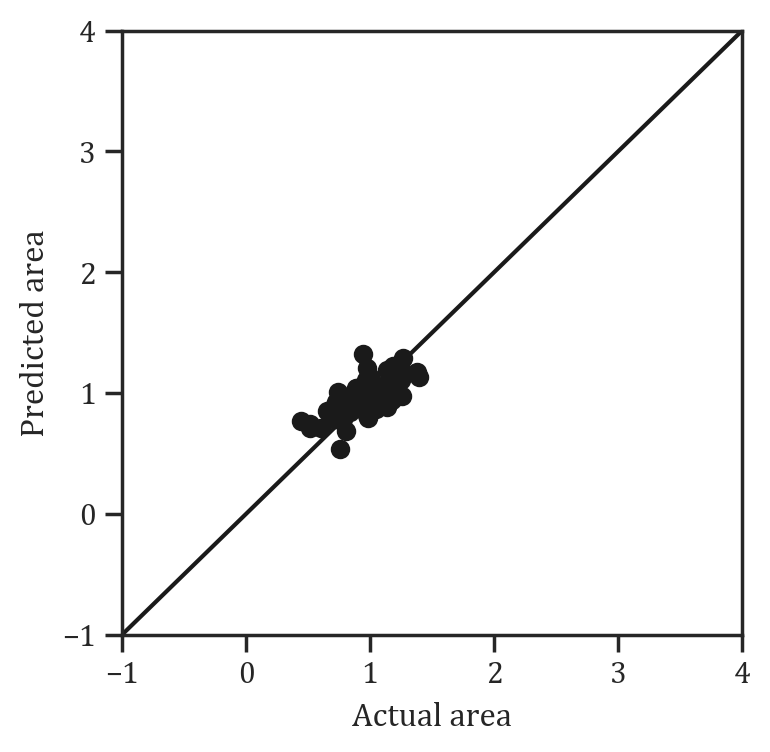

In [18]:
# y-y plot (statsmodels)
y_hat = model.predict(df)
y_train = df['area']

sns.set_theme(style='ticks', color_codes=True)
mpl.rcParams.update({'font.sans-serif':'Cambria'})
fig, ax = plt.subplots(dpi=200, figsize=[4, 4])
ax.scatter(y_train, y_hat, color='k')
ax.set_ylabel('Predicted area')
ax.set_xlabel('Actual area')
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)
ax.set_xticks(np.arange(-1, 5, 1))
ax.set_yticks(np.arange(-1, 5, 1))
ax.plot([-1, 4], [-1, 4], color='k')
#fig.savefig('plots/y-y_plot.png')

In [20]:
coef_var_names = ['intercept',                      #x_train.design_info.column_names
                  '$\mathregular{x_{Ageing}}$',
                  '$\mathregular{x_{Dropwise}}$',
                  '$\mathregular{x_{In-situ}}$',
                  '$\mathregular{x_{Annealed}}$',
                  '$\mathregular{x_{H_2SO_4}}$',
                  '$\mathregular{x_{HNO_3}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}}}$',
                  '$\mathregular{x_{NaOH}}$',
                  '$\mathregular{x_{Co-LDH}}$',
                  '$\mathregular{x_{Fe-LDH}}$',
                  '$\mathregular{x_{Annealed}x_{Ageing}}$',
                  '$\mathregular{x_{Annealed}x_{Dropwise}}$',
                  '$\mathregular{x_{Annealed}x_{In-Situ}}$',
                  '$\mathregular{x_{H_2SO_4}x_{Ageing}}$',
                  '$\mathregular{x_{H_2SO_4}x_{Dropwise}}$',
                  '$\mathregular{x_{H_2SO_4}x_{In-Situ}}$',
                  '$\mathregular{x_{HNO_3}x_{Ageing}}$',
                  '$\mathregular{x_{HNO_3}x_{Dropwise}}$',
                  '$\mathregular{x_{HNO_3}x_{In-Situ}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}x_{Ageing}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}x_{Dropwise}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}x_{In-Situ}}$',
                  '$\mathregular{x_{NaOH}x_{Ageing}}$',
                  '$\mathregular{x_{NaOH}x_{Dropwise}}$',
                  '$\mathregular{x_{NaOH}x_{In-Situ}}$',
                  '$\mathregular{x_{Ageing}x_{Co-LDH}}$',
                  '$\mathregular{x_{Dropwise}x_{Co-LDH}}$',
                  '$\mathregular{x_{In-situ}x_{Co-LDH}}$',
                  '$\mathregular{x_{Ageing}x_{Fe-LDH}}$',
                  '$\mathregular{x_{Dropwise}x_{Fe-LDH}}$',
                  '$\mathregular{x_{In-situ}x_{Fe-LDH}}$',
                  '$\mathregular{x_{Annealed}x_{H_2SO_4}}$',
                  '$\mathregular{x_{Annealed}x_{HNO_3}}$',
                  '$\mathregular{x_{Annealed}x_{HNO_3 + H_2SO_4}}$',
                  '$\mathregular{x_{Annealed}x_{NaOH}}$',
                  '$\mathregular{x_{Annealed}x_{Co-LDH}}$',
                  '$\mathregular{x_{Annealed}x_{Fe-LDH}}$',
                  '$\mathregular{x_{H_2SO_4}x_{Co-LDH}}$',
                  '$\mathregular{x_{HNO_3}x_{Co-LDH}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}x_{Co-LDH}}$',
                  '$\mathregular{x_{NaOH}x_{Co-LDH}}$',
                  '$\mathregular{x_{H_2SO_4}x_{Fe-LDH}}$',
                  '$\mathregular{x_{HNO_3}x_{Fe-LDH}}$',
                  '$\mathregular{x_{HNO_3 + H_2SO_4}x_{Fe-LDH}}$',
                  '$\mathregular{x_{NaOH}x_{Fe-LDH}}$']

conf_int_err = model.params - model.conf_int()[0]
df_coef = pd.DataFrame({'coef': model.params.values,
                        'err': conf_int_err.values,
                        'var_name': coef_var_names})
df_coef.sort_values(by='coef', ascending=False, inplace=True)
df_coef.reset_index(drop=True, inplace=True)

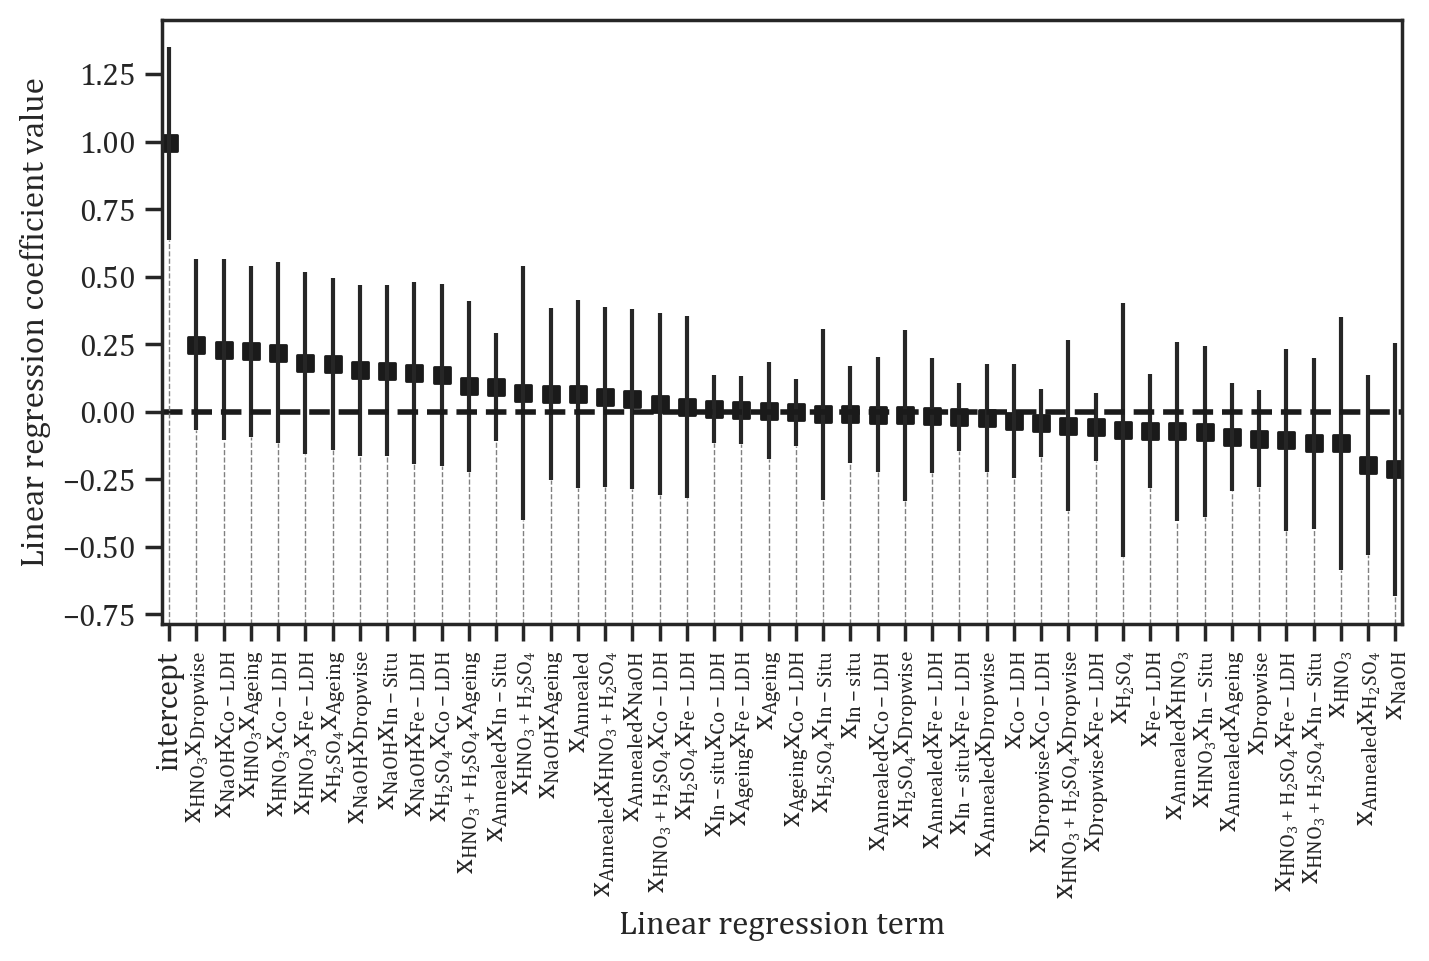

In [21]:
fig, ax = plt.subplots(dpi=200, figsize=(8, 4))
df_coef.plot(x='var_name', y='coef', kind='scatter', ax=ax, color='k', marker='s', s=30, legend=False)
df_coef.plot(x='var_name', y='coef', kind='bar', ax=ax, yerr='err', width=0, legend=False)
ax.axhline(y=0, linestyle='dashed', color='k', lw=2)

x_ticks = ax.get_xticks()
ymin_plot, ymax_plot = ax.get_ylim()
for i in range(len(df_coef)): 
    ymax = (df_coef['coef'][i] - df_coef['err'][i] - ymin_plot)/(ymax_plot - ymin_plot)
    ax.axvline(x=x_ticks[i], ymin=0, ymax=ymax, color='grey', ls='dashed', lw=0.5)
    
ax.set_xlabel('Linear regression term')
ax.set_ylabel('Linear regression coefficient value')
for tick in ax.get_xticklabels(): tick.set_rotation(90)
#fig.savefig('plots/regression_interactions.png', bbox_inches='tight')